# Deep Convolutional GAN - MNIST Dataset

In this notebook we are going to implement a little more complicated GAN, a Deep Convolutional one. like previous notebooks we will use MNIST dataset and PyTorch as deep learning framework.

Deep Convolutional GAN was developed in 2015 for the first time and the reference paper of it can be accessed from [here](https://arxiv.org/pdf/1511.06434v1.pdf).

Architecture of the network is like this:

Generator:
1. Noise vector: (64)
2. Block1: [ConvTranspose(64, 256), Filter: 3, Stride: 2] -> BatchNormalization(256) -> ReLU
3. Block2: [ConvTranspose(256, 128), Filter: 4, Stride: 1] -> BatchNormalization(128) -> ReLU
4. Block3: [ConvTranspose(128, 64), Filter: 3, Stride: 2] -> BatchNormalization(128) -> ReLU
5. Block4: [ConvTranspose(64, 1), Filter: 4, Stride: 2] -> Tanh

Discriminator:
1. Image: (28, 28, 1)
2. Block1: [Conv2D(1, 16), Filter: 4, Stride: 2] -> BatchNormalization(16) -> LeakyReLU(0.2)
3. Block2: [Conv2D(16, 32), Filter: 4, Stride: 2] -> BatchNormalization(32) -> LeakyReLU(0.2)
4. Block3: [Conv2D(32, 1), Filter: 4, Stride: 2]

Features of this network are listed here:
- No pooling layer
- batch normalization in generator and discriminator
- No Fully connected layer
- ReLU activation in generator for all layers except the last layer, which is Tanh
- LeakyReLU activation in discriminator for all layers except the last layer which don't need activation.

You might be wondering why we are using Transposed Convolution in Generator. Transposed Convolutions are also known as DeConvolutions. This means that they are operating as an upsampling with a filter. We are using Transposed Convolution becuase we want to make our noise which is a vector to an image which is a 3D Tensor.

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def generate_noise(n_samples, noise_dim, device = 'cpu'):
    '''
    A Helper function for creating random noise vectors with the dimension of: (n_samples, noise_dim)
    random numbers are from normal distribution
    Input ->
        n_samples: number of samples to generate (row)
        noise_dim: dimension of nouse vector (column)
        device: device type
    '''
    return torch.randn(n_samples, noise_dim, device=device)

## Generator

In [2]:
class Generator(nn.Module):
    '''
    This class is for generator.
    Inputs ->
        noise_dim: dimension of noise vector.
        image_channel: number of channels in images,(Since MNIST is black and white images have 1 channel.)
        hidden_dim: inner dimension of networks.
    '''
    def __init__(self, noise_dim=10, image_channel=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.block1 = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, hidden_dim * 4, kernel_size=3, stride=2),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.ReLU()
        )
        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU()
        )
        self.block3 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, kernel_size=3, stride=2),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU()
        )
        self.block4 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim, image_channel, kernel_size=4, stride=2),
            nn.Tanh()
        )
    
    def unsqueeze_noise(self, noise):
        '''
        A helper function for reshaping the noise vector. reshaping noise vector to (number of samples, noise_dim, 1, 1)
        Input ->
            a noise tensor with the shape of (number of samples, noise_dim)
        Output ->
            a copy of noise with shape of (number of samples, noise_dim, 1, 1)
        '''
        return noise.view(len(noise), self.noise_dim, 1, 1)
    
    def forward(self, noise):
        '''
        forward pass of generator.
        Input ->
            noise: noise tensor with shape of (number of samples, noise_dim)
        Output ->
            generated image
        '''
        out = self.unsqueeze_noise(noise)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        return out

## Discriminator

In [3]:
class Discriminator(nn.Module):
    '''
    This class is for Dsicriminator
    Input ->
        image_channel: number of channels in images,(Since MNIST is black and white images have 1 channel.)
        hidden_dim: inner dimension of networks.
    '''
    def __init__(self, image_channel=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(image_channel, hidden_dim, kernel_size=4, stride=2),
            nn.BatchNorm2d(hidden_dim),
            nn.LeakyReLU(.2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=4, stride=2),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(.2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(hidden_dim * 2, 1, kernel_size=4, stride=2)
        )
    def forward(self, image):
        '''
        Forward pass of discriminator
        Input ->
            image: flattened image tensor with dimension of (image_dim)
        Output ->
            returns a 1 dimension tensor representing whtether input image is generated or original.
        '''
        out = self.block1(image)
        out = self.block2(out)
        out = self.block3(out)
        return out.view(len(out), -1)

## Training

Like previous networks, we have some hyperparameters to address before beginning the training phase. you can see some of them here:

- Criterion: the loss function we want to use for our network
- n_epochs: number of epochs we want to train our network
- noise_dim: the dimension of noise vector
- display_step: in what steps we want to see a sample from generator
- batch_size: the size of our batch i.e. number of images to be passed to processod in forward and backward pass.
- lr: learning rate
- beta_1, beta_2: hyperparameters for momentum
- device: device type

In [6]:
criterion = nn.BCEWithLogitsLoss()
noise_dim = 64
display_step = 500
batch_size = 128
lr = .0002
beta_1 = .5
beta_2 = .999
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5,), (.5)),
])

dataloader = DataLoader(
    MNIST('./data', download=True, transform=transform),
    batch_size=batch_size, shuffle=True
)

In [7]:
gen = Generator(noise_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

Initializing weights to the normal distribution with mean of 0 and standard deviation of 0.02

In [8]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

  6%|▋         | 30/469 [00:02<00:40, 10.89it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1, Step 500 -> Generator loss: 1.023333115935326, discriminator loss: 0.4706256099641326


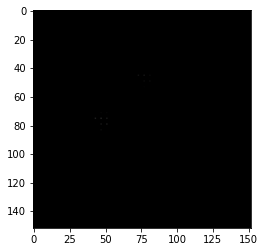

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


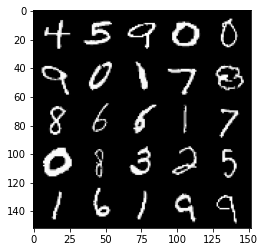

 13%|█▎        | 62/469 [00:05<00:38, 10.49it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2, Step 1000 -> Generator loss: 2.667801036834716, discriminator loss: 0.09682307601720105


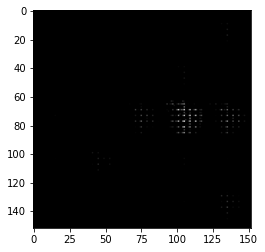

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


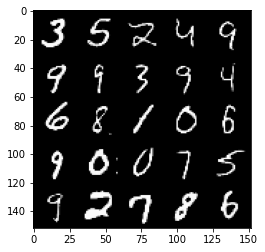

 20%|█▉        | 93/469 [00:09<00:36, 10.39it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3, Step 1500 -> Generator loss: 2.880452744394541, discriminator loss: 0.1942758893556892


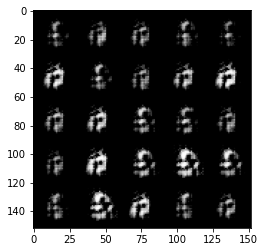

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


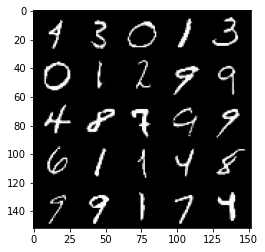

 26%|██▋       | 124/469 [00:12<00:36,  9.46it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 4, Step 2000 -> Generator loss: 1.7510962737128144, discriminator loss: 0.3977774573415514


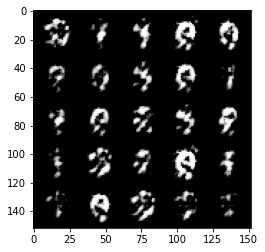

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


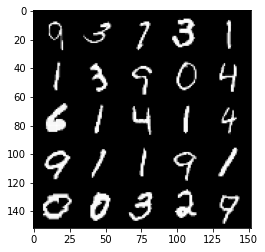

 33%|███▎      | 155/469 [00:15<00:32,  9.70it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 5, Step 2500 -> Generator loss: 1.42668802511692, discriminator loss: 0.43327729159593564


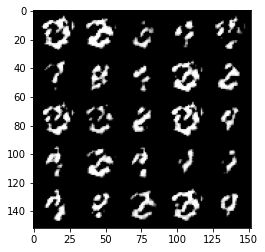

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


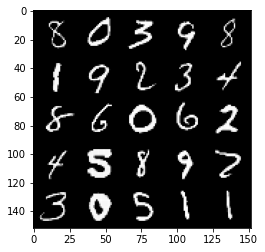

 40%|███▉      | 186/469 [00:19<00:30,  9.28it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 6, Step 3000 -> Generator loss: 1.2271358238756669, discriminator loss: 0.48467371189594294


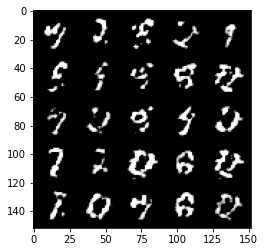

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


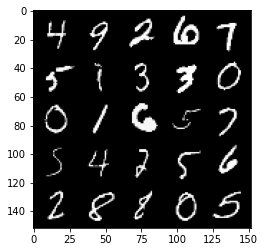

 46%|████▋     | 217/469 [00:30<00:34,  7.27it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 7, Step 3500 -> Generator loss: 1.0086355640888205, discriminator loss: 0.5599917694926257


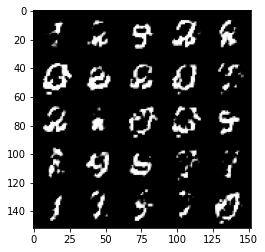

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


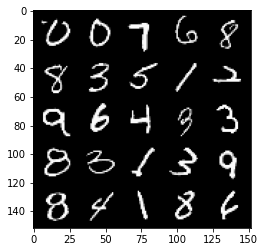

 53%|█████▎    | 248/469 [00:35<00:33,  6.67it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 8, Step 4000 -> Generator loss: 0.9030653799474251, discriminator loss: 0.6073752558827398


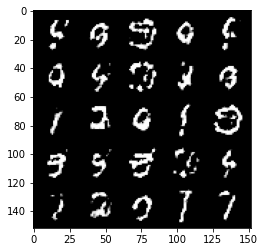

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


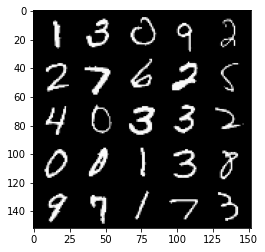

 59%|█████▉    | 279/469 [00:51<00:34,  5.48it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 9, Step 4500 -> Generator loss: 0.8391644552350038, discriminator loss: 0.6280971872806546


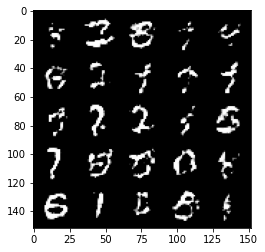

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


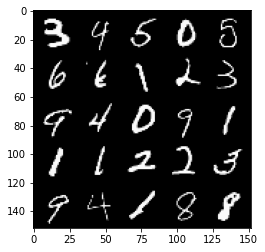

 66%|██████▌   | 310/469 [01:02<00:30,  5.15it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 10, Step 5000 -> Generator loss: 0.822732839822769, discriminator loss: 0.6442055417299272


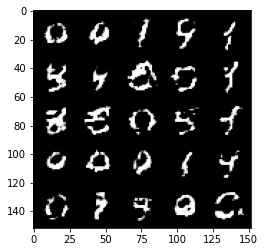

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


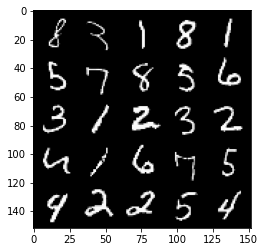

 73%|███████▎  | 341/469 [01:03<00:23,  5.40it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 11, Step 5500 -> Generator loss: 0.8107443764209746, discriminator loss: 0.6574988267421724


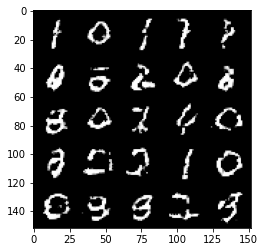

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


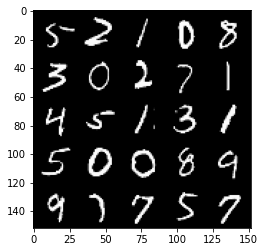

 79%|███████▉  | 372/469 [00:52<00:13,  6.97it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 12, Step 6000 -> Generator loss: 0.7844752247929571, discriminator loss: 0.666432977318764


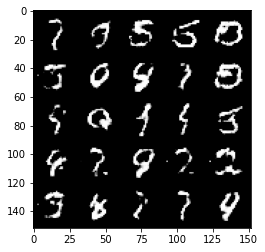

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


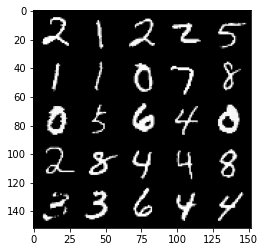

 86%|████████▌ | 403/469 [00:56<00:09,  7.18it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 13, Step 6500 -> Generator loss: 0.7667748318910608, discriminator loss: 0.6730719962120058


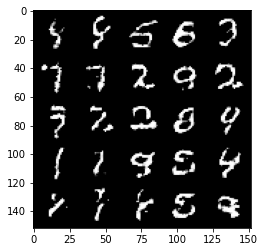

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


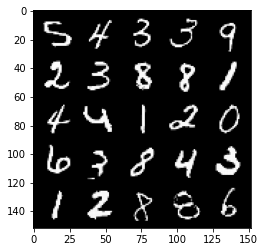

 93%|█████████▎| 434/469 [01:09<00:06,  5.21it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 14, Step 7000 -> Generator loss: 0.7593137623071661, discriminator loss: 0.681104696989059


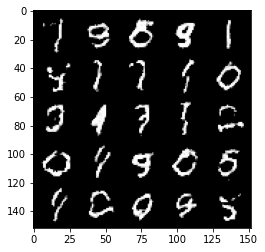

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


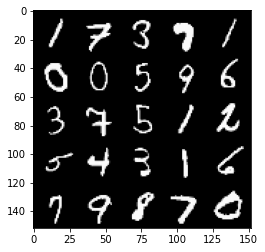

 99%|█████████▉| 465/469 [01:16<00:00,  6.49it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 15, Step 7500 -> Generator loss: 0.7511761513948445, discriminator loss: 0.6830425997972488


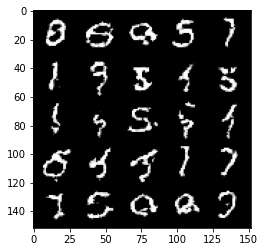

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


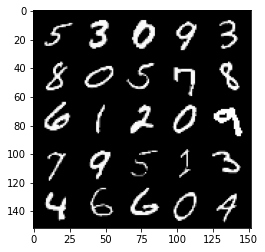

  6%|▌         | 27/469 [00:03<01:03,  7.00it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 17, Step 8000 -> Generator loss: 0.7392115812301641, discriminator loss: 0.6861208425760269


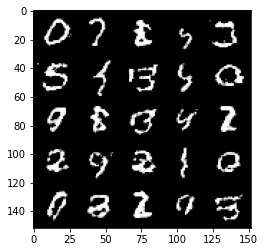

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


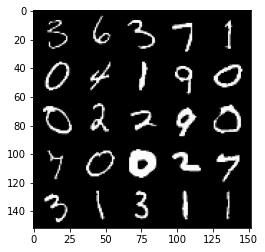

 12%|█▏        | 58/469 [00:07<00:54,  7.50it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 18, Step 8500 -> Generator loss: 0.7386610203385342, discriminator loss: 0.6857267858982088


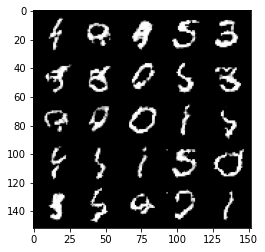

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


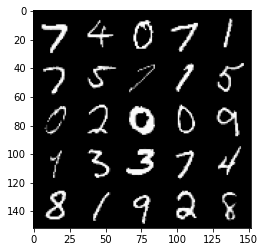

 19%|█▉        | 89/469 [00:09<00:40,  9.37it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 19, Step 9000 -> Generator loss: 0.7353383357524873, discriminator loss: 0.6881744418144234


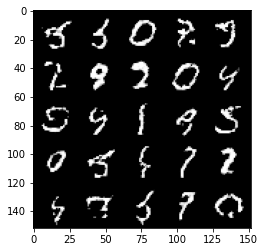

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


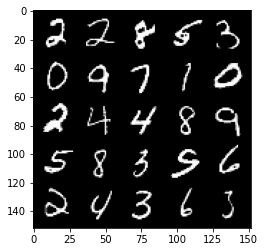

 26%|██▌       | 120/469 [00:11<00:33, 10.29it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 20, Step 9500 -> Generator loss: 0.7269747749567024, discriminator loss: 0.691909653782845


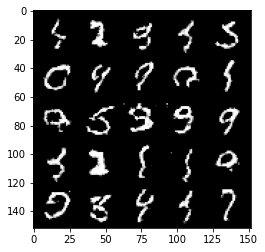

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


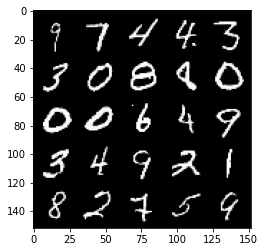

 32%|███▏      | 151/469 [00:15<00:33,  9.52it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 21, Step 10000 -> Generator loss: 0.7233702152967458, discriminator loss: 0.6927301433086395


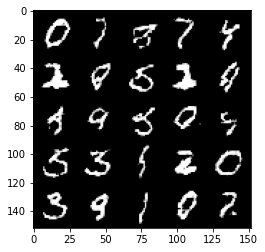

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


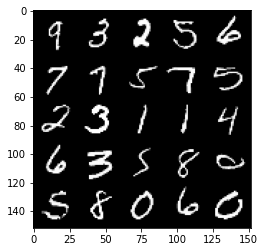

 39%|███▉      | 182/469 [00:22<00:34,  8.33it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 22, Step 10500 -> Generator loss: 0.7203601363897322, discriminator loss: 0.6930514508485797


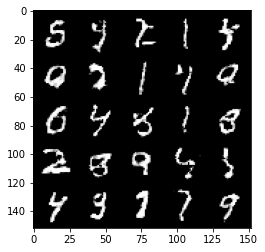

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


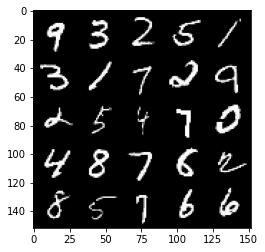

 45%|████▌     | 213/469 [00:25<00:30,  8.26it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 23, Step 11000 -> Generator loss: 0.7221276949644088, discriminator loss: 0.6929171969890593


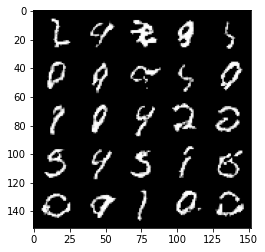

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


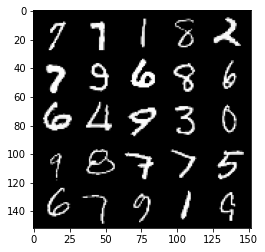

 52%|█████▏    | 244/469 [00:28<00:27,  8.09it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 24, Step 11500 -> Generator loss: 0.7162965229153634, discriminator loss: 0.6946918590068811


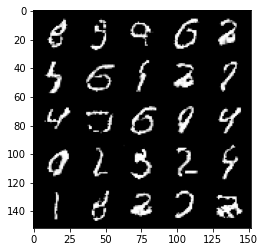

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


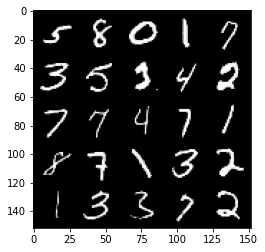

 59%|█████▊    | 275/469 [00:31<00:22,  8.52it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 25, Step 12000 -> Generator loss: 0.7143576785326011, discriminator loss: 0.6947503319978722


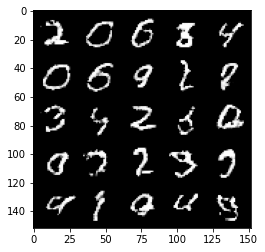

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


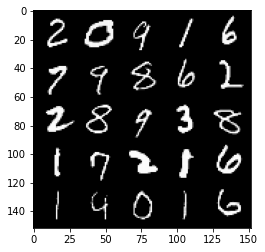

 65%|██████▌   | 306/469 [00:35<00:18,  8.81it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 26, Step 12500 -> Generator loss: 0.7108955814838401, discriminator loss: 0.6974525845050806


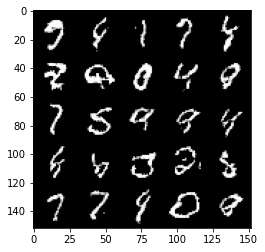

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


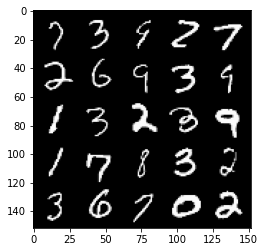

 72%|███████▏  | 337/469 [00:38<00:17,  7.42it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 27, Step 13000 -> Generator loss: 0.7100302911996841, discriminator loss: 0.6971674134731294


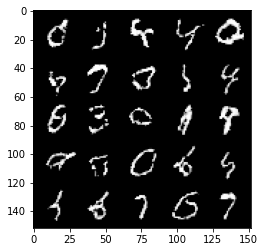

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


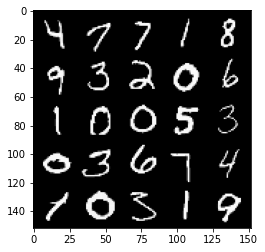

 78%|███████▊  | 368/469 [00:43<00:11,  8.83it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 28, Step 13500 -> Generator loss: 0.7079693858623503, discriminator loss: 0.6987180138826371


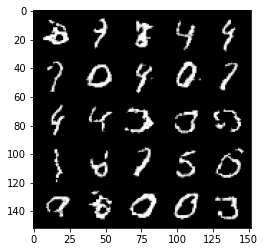

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


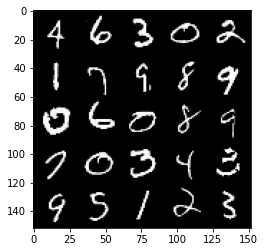

 85%|████████▌ | 399/469 [00:46<00:08,  8.71it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 29, Step 14000 -> Generator loss: 0.7079534164667127, discriminator loss: 0.6988920823335653


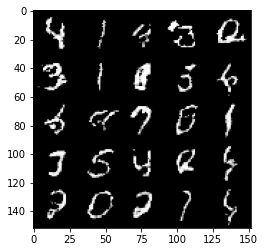

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


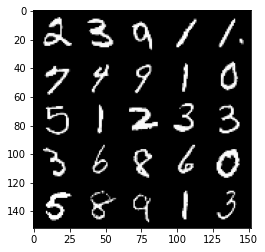

 92%|█████████▏| 430/469 [00:50<00:04,  8.48it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 30, Step 14500 -> Generator loss: 0.7035157251358036, discriminator loss: 0.6993961700201036


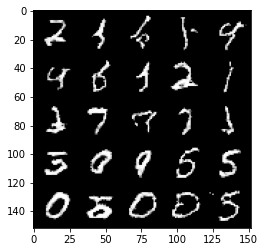

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


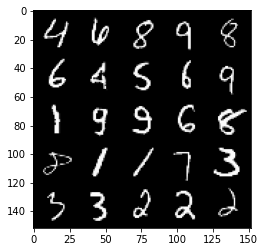

 98%|█████████▊| 461/469 [00:54<00:00,  8.52it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 31, Step 15000 -> Generator loss: 0.703436859726906, discriminator loss: 0.6997093617916114


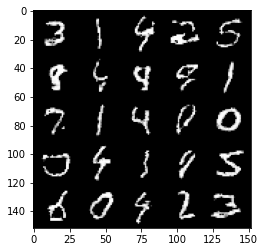

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


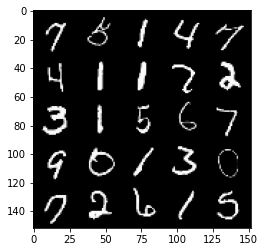

  5%|▍         | 23/469 [00:02<00:50,  8.80it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 33, Step 15500 -> Generator loss: 0.7026034195423123, discriminator loss: 0.6990421177148823


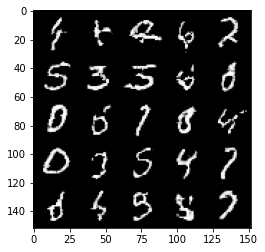

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


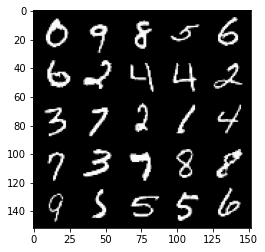

 12%|█▏        | 54/469 [00:06<00:58,  7.05it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 34, Step 16000 -> Generator loss: 0.6997083667516711, discriminator loss: 0.6988953154087068


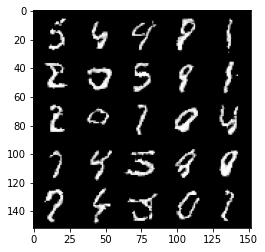

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


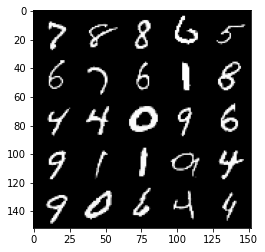

 18%|█▊        | 85/469 [00:09<00:44,  8.70it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 35, Step 16500 -> Generator loss: 0.7000321176052098, discriminator loss: 0.6997848379611973


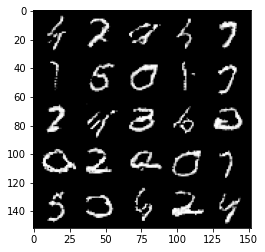

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


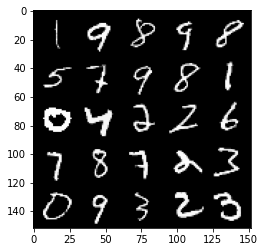

 25%|██▍       | 116/469 [00:12<00:38,  9.15it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 36, Step 17000 -> Generator loss: 0.6970182778835292, discriminator loss: 0.6996576677560801


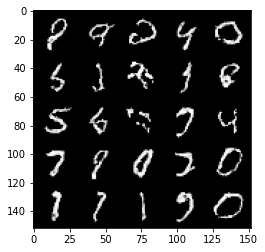

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


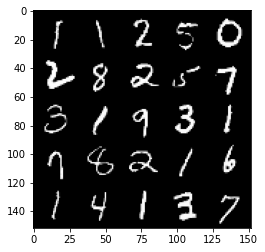

 31%|███▏      | 147/469 [00:16<00:35,  9.16it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 37, Step 17500 -> Generator loss: 0.6998991723060604, discriminator loss: 0.6996488074064254


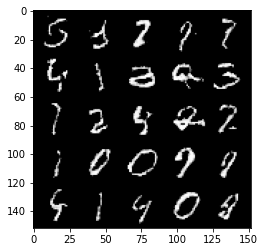

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


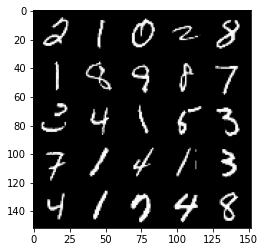

 38%|███▊      | 178/469 [00:19<00:35,  8.22it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 38, Step 18000 -> Generator loss: 0.696147113084793, discriminator loss: 0.6989460996389384


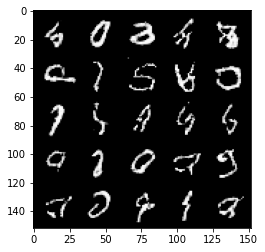

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


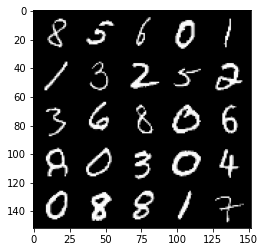

 45%|████▍     | 209/469 [00:20<00:25, 10.30it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 39, Step 18500 -> Generator loss: 0.6968745787143713, discriminator loss: 0.6986745182275785


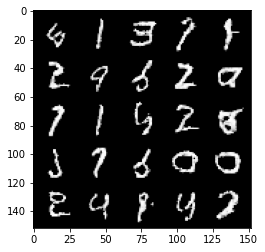

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


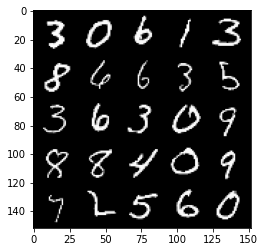

 51%|█████     | 240/469 [00:23<00:22, 10.05it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 40, Step 19000 -> Generator loss: 0.6967551032304767, discriminator loss: 0.6985122269392027


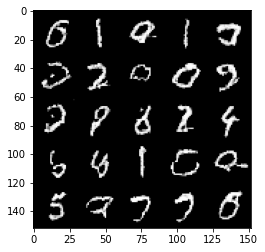

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


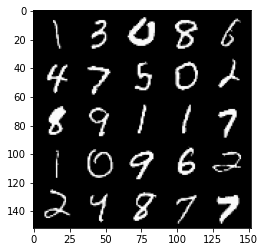

 58%|█████▊    | 271/469 [00:26<00:19, 10.08it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 41, Step 19500 -> Generator loss: 0.6949736826419828, discriminator loss: 0.6979883621931077


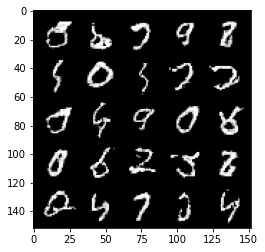

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


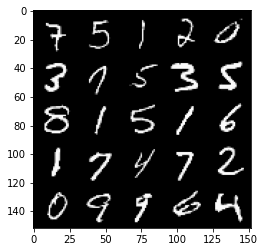

 64%|██████▍   | 302/469 [00:29<00:16,  9.98it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 42, Step 20000 -> Generator loss: 0.6961075615882877, discriminator loss: 0.697935058236122


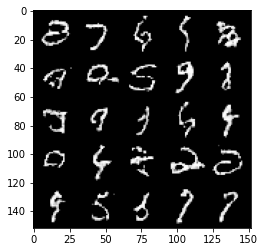

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


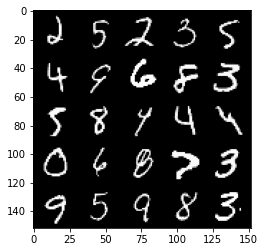

 71%|███████   | 333/469 [00:35<00:15,  9.01it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 43, Step 20500 -> Generator loss: 0.6967242122888568, discriminator loss: 0.6978850022554394


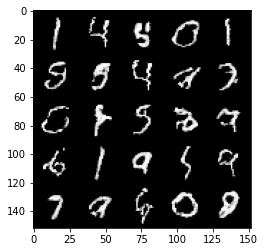

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


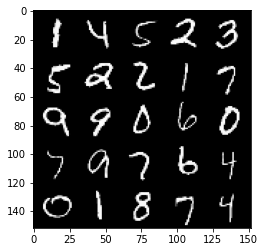

 78%|███████▊  | 364/469 [00:40<00:12,  8.21it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 44, Step 21000 -> Generator loss: 0.6954332612752909, discriminator loss: 0.6970556145906446


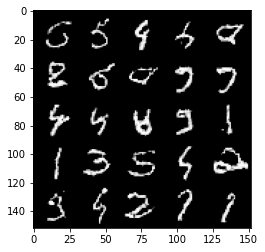

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


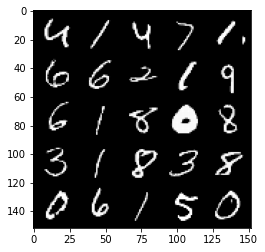

 84%|████████▍ | 395/469 [00:48<00:08,  8.34it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 45, Step 21500 -> Generator loss: 0.6957097806930534, discriminator loss: 0.6969086651802068


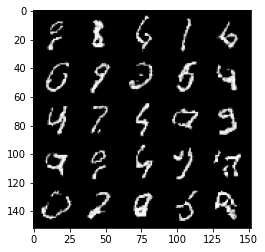

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


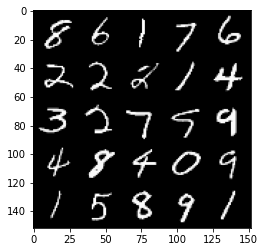

 91%|█████████ | 426/469 [00:51<00:06,  7.13it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 46, Step 22000 -> Generator loss: 0.6952036126852036, discriminator loss: 0.6965869933366775


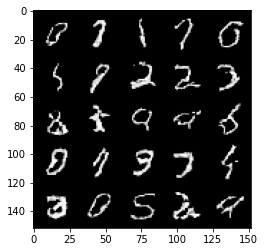

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


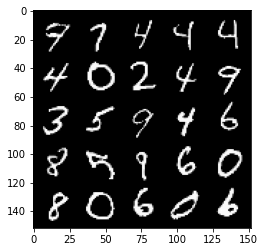

 97%|█████████▋| 457/469 [00:52<00:01,  8.87it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 47, Step 22500 -> Generator loss: 0.6954161245822912, discriminator loss: 0.6965242185592658


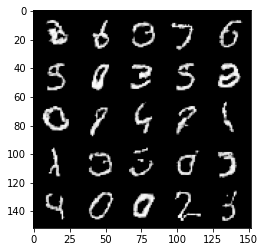

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


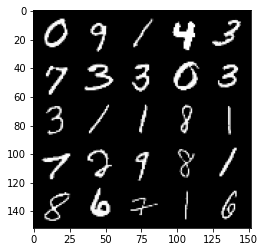

  4%|▍         | 19/469 [00:02<00:48,  9.22it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 49, Step 23000 -> Generator loss: 0.6952557202577596, discriminator loss: 0.6960248352289198


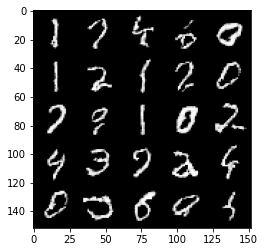

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


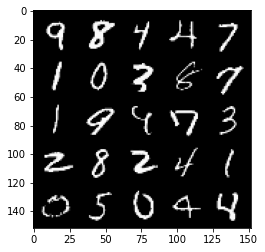

100%|██████████| 469/469 [00:49<00:00,  9.53it/s]


In [9]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for original, _ in tqdm(dataloader):
        cur_batch_size = len(original)
        original = original.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        generated_noise = generate_noise(cur_batch_size, noise_dim, device=device)
        generated = gen(generated_noise)
        disc_generated_pred = disc(generated.detach())
        disc_generated_loss = criterion(disc_generated_pred, torch.zeros_like(disc_generated_pred))
        disc_original_pred = disc(original)
        disc_original_loss = criterion(disc_original_pred, torch.ones_like(disc_original_pred))
        disc_loss = (disc_generated_loss + disc_original_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        generated_noise_2 = generate_noise(cur_batch_size, noise_dim, device=device)
        generated_2 = gen(generated_noise_2)
        disc_generated_pred = disc(generated_2)
        gen_loss = criterion(disc_generated_pred, torch.ones_like(disc_generated_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch}, Step {cur_step} -> Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(generated)
            show_tensor_images(original)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

In [10]:
torch.save(gen.state_dict(), 'models/MNIST-DCGAN-Gen-v1.0.pth')
torch.save(disc.state_dict(), 'models/MNIST-DCGAN-Disc-v1.0.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


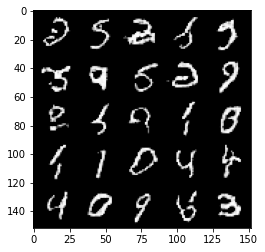

In [11]:
test_noise = generate_noise(25, 64, device='cuda')
generated_test = gen(test_noise)
show_tensor_images(generated_test)

--------
# Ramin F. - @SimplyRamin